#**DSCI 631 Final Project**

- Group member
    - Name: Jonathan Watkins
    - Email: jfw68@drexel.edu
- Group member
    - Name: Jake Jarosik
    - Email: jj3268@drexel.edu
- Group member
    - Name: Jimmy Zhang
    - Email: jz876@drexel.edu


In [ ]:
# Documentation and resources:
# https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet
# https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors
# https://neptune.ai/blog/arima-vs-prophet-vs-lstm
# https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a
# https://www.kaggle.com/code/inmanenz/prophet-ts-split-and-plotnine


##**Setup for Prophet**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#additional packages
%pip install prophet
%pip install pytorch-ignite
%pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import logging
logging.getLogger('prophet').setLevel(logging.CRITICAL)

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from plotnine import *

In [ ]:
#metrics
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from ignite.metrics import RootMeanSquaredError as RMSE
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError as SMAPE
from torchmetrics.nominal import TheilsU
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics #RMSE will be our main metric

#splitting time series
from sklearn.model_selection import TimeSeriesSplit

##**Prophet Model 1 - Understanding How Prophet Works (Auto Regression with no Train/Test Split or Cross Validation)**

In [ ]:
#load index fund price data
df = pd.read_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/StockData/All Current S&P 500 Constituents/^GSPC.csv')

df.head()

Date         Open         High          Low  \
0  2008-01-02 00:00:00-05:00  1467.969971  1471.770020  1442.069946   
1  2008-01-03 00:00:00-05:00  1447.550049  1456.800049  1443.729980   
2  2008-01-04 00:00:00-05:00  1444.010010  1444.010010  1411.189941   
3  2008-01-07 00:00:00-05:00  1414.069946  1423.869995  1403.449951   
4  2008-01-08 00:00:00-05:00  1415.709961  1430.280029  1388.300049   

         Close      Volume  Dividends  Stock Splits  
0  1447.160034  3452650000        0.0           0.0  
1  1447.160034  3429500000        0.0           0.0  
2  1411.630005  4166000000        0.0           0.0  
3  1416.180054  4221260000        0.0           0.0  
4  1390.189941  4705390000        0.0           0.0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015 entries, 0 to 4014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4015 non-null   object 
 1   Open          4015 non-null   float64
 2   High          4015 non-null   float64
 3   Low           4015 non-null   float64
 4   Close         4015 non-null   float64
 5   Volume        4015 non-null   int64  
 6   Dividends     4015 non-null   float64
 7   Stock Splits  4015 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 251.1+ KB


In [ ]:
#function to convert to pandas of string of time to date
from dateutil import parser
from datetime import datetime

def transform_to_date(pandas_object, col_name=''):
  if col_name == '':
    pandas_object = pandas_object.apply(parser.parse).apply(datetime.date)
    return pandas_object
  else:
    pandas_object[col_name] = pandas_object['col_name'].apply(parser.parse).apply(datetime.date)
    return pandas_object[col_name]

In [ ]:
df['Date'] = transform_to_date(df['Date'])

In [ ]:
#rename again - to fit prophet required column name
df = df.rename(columns={'Date': 'ds',
                        'Close': 'y'})

df.head()

ds         Open         High          Low            y      Volume  \
0  2008-01-02  1467.969971  1471.770020  1442.069946  1447.160034  3452650000   
1  2008-01-03  1447.550049  1456.800049  1443.729980  1447.160034  3429500000   
2  2008-01-04  1444.010010  1444.010010  1411.189941  1411.630005  4166000000   
3  2008-01-07  1414.069946  1423.869995  1403.449951  1416.180054  4221260000   
4  2008-01-08  1415.709961  1430.280029  1388.300049  1390.189941  4705390000   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0

In [ ]:
df_sub = df[['ds', 'y']]

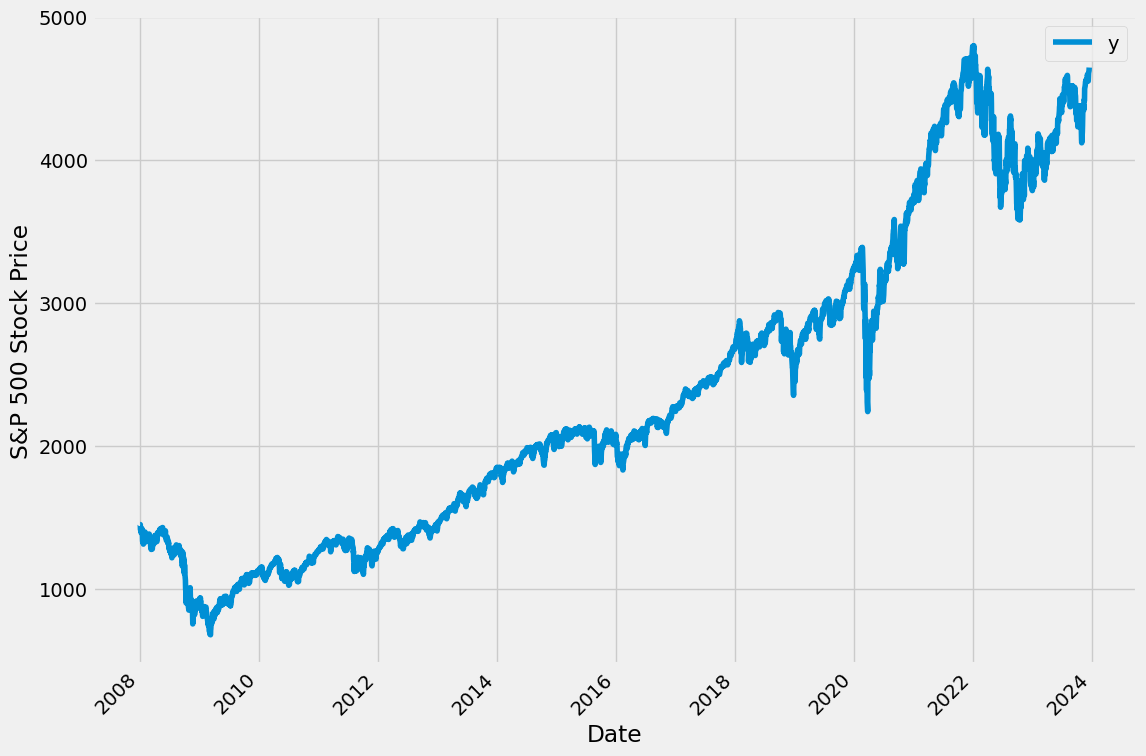

In [ ]:
ax = df_sub.set_index('ds').plot(figsize=(12, 8))
plt.xticks(rotation=45, ha="right")
ax.set_ylabel('S&P 500 Stock Price')
ax.set_xlabel('Date')

plt.show()

In [ ]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
# this is Prophet as an auto regressive model with all target samples with no splits
# Note: an instance of the Prophet class can only be used / fit() once
#my_model = Prophet()
my_model = Prophet(interval_width=0.95)
my_model.fit(df_sub)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/570evwaa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/qgtihl6_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34503', 'data', 'file=/tmp/tmpneybixq0/570evwaa.json', 'init=/tmp/tmpneybixq0/qgtihl6_.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modelzek0mgfk/prophet_model-20231213181918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future_dates = my_model.make_future_dataframe(periods=30, freq='MS')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds         yhat   yhat_lower   yhat_upper
0    2008-01-02  1501.773582  1194.152036  1828.218367
1    2008-01-03  1501.532329  1183.644227  1861.748545
2    2008-01-04  1500.981726  1159.364297  1822.488240
3    2008-01-07  1497.957900  1164.154690  1823.212875
4    2008-01-08  1496.914387  1179.849236  1830.238935
...         ...          ...          ...          ...
4040 2026-02-01  4769.316155  3505.331207  6088.312839
4041 2026-03-01  4762.590533  3363.577445  6138.211048
4042 2026-04-01  4806.016276  3316.653739  6209.336088
4043 2026-05-01  4835.775984  3366.617709  6391.521448
4044 2026-06-01  4843.757938  3253.251955  6445.613067

[4045 rows x 4 columns]

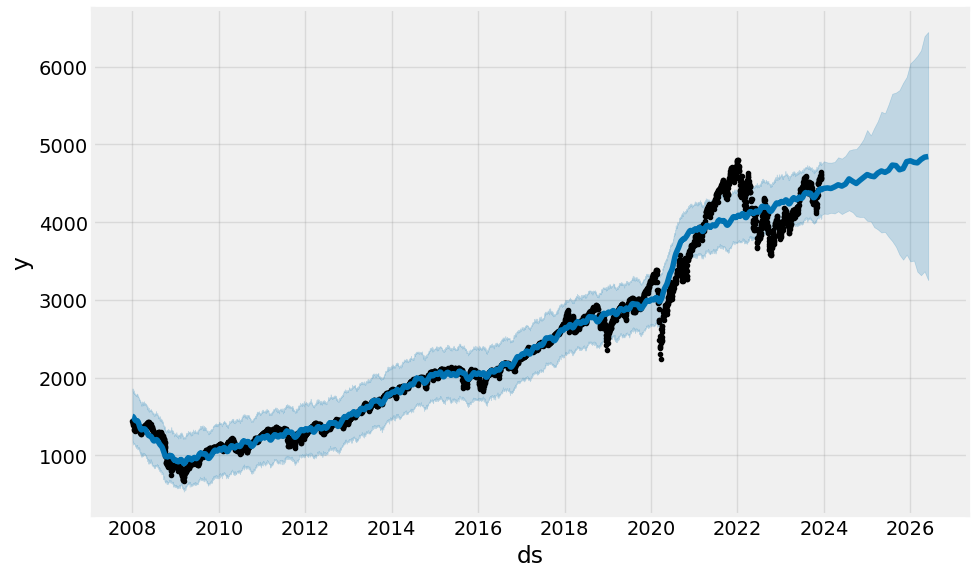

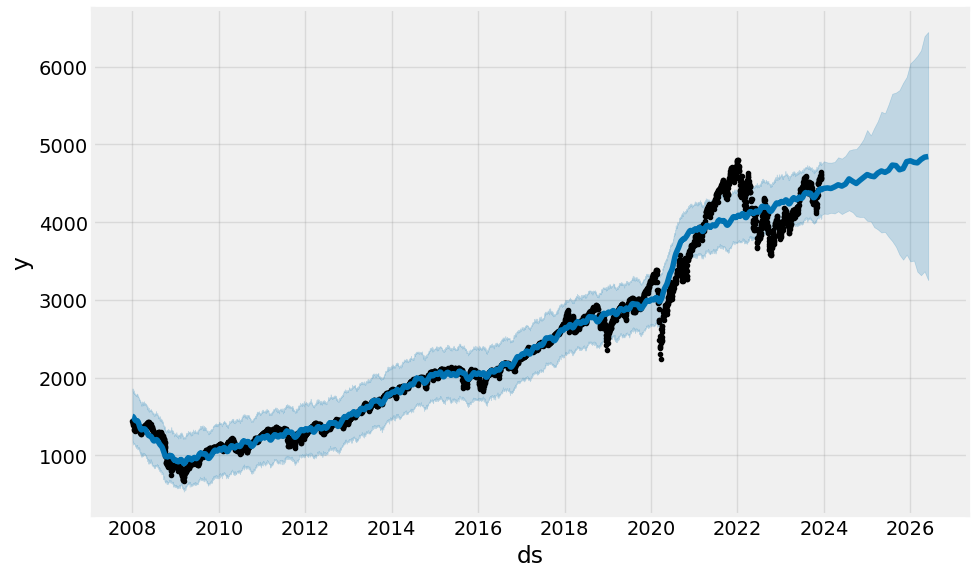

In [ ]:
my_model.plot(forecast, uncertainty=True)

##**Prophet Model 2 - Auto Regression with Train/Test Split and Cross Validation - Comparing Seasonality Settings**

In [ ]:
#redo above with splitting and wrap in function

def pro_ds_data_gen(df,yearly_seasonality=True,weekly_seasonality=False,daily_seasonality=False, add_regressors=None, add_holidays=None):
    out_df=pd.DataFrame()

    #Initialize Split Class, we'll split our data 4 times for cv
    tscv = TimeSeriesSplit(n_splits=4)

    #Initialize individual cv metric results dataframe
    model_metrics_cv = pd.DataFrame()

    for i, (train_i,test_i) in enumerate(tscv.split(df)): #For Time Series Split

        #Use indexes to grab the correct data for this split
        train_df=df.copy().iloc[train_i,:]
        test_df=df.copy().iloc[test_i,:]

        #Build our model using prophet and make predictions on the test set
        my_model=Prophet(
                interval_width=0.95,
                yearly_seasonality=yearly_seasonality,
                weekly_seasonality=weekly_seasonality,
                daily_seasonality=daily_seasonality,
                holidays=add_holidays
                )

        #If a iterable of regressors are passed into the function, add regressors
        if add_regressors:
          for regressor_name in add_regressors:
            my_model.add_regressor(regressor_name)

        #fit and predict
        my_model.fit(train_df)
        predictions=my_model.predict(test_df)

        #Combine predictions and training into one df for plotting
        pred_df=predictions.loc[:,["ds","yhat"]]
        pred_df["y"]=test_df.y.tolist()
        train_df["train"]="Train"
        pred_df["train"]="Test"
        sub_df=train_df.append(pred_df).reset_index(drop=True)
        sub_df["split"]="Split "+str(i+1)
        sub_df["rmse"]=(np.mean((sub_df.yhat-sub_df.y)**2))**.5 #manually calculating rmse for the split
        out_df=out_df.append(sub_df).reset_index(drop=True)

        #use built in cross-validation object and get built-in metrics
        df_cv = cross_validation(my_model,
                                horizon='30 days',
                                initial='365 days')
        model_metrics_cv_i = performance_metrics(df_cv)
        model_metrics_cv_i['Train/Test Split'] = f'Split {i}'
        if  i == 0: #first cv metrics
          model_metrics_cv = model_metrics_cv_i
        else:
          model_metrics_cv = pd.concat([model_metrics_cv, model_metrics_cv_i], ignore_index=True)

    return (out_df, my_model, model_metrics_cv)

In [ ]:
#call above function
df_results_1, my_model_1, model_cv_metrics_1 = pro_ds_data_gen(df_sub)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/bzr9jfb1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/7_mo68tq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5822', 'data', 'file=/tmp/tmpneybixq0/bzr9jfb1.json', 'init=/tmp/tmpneybixq0/7_mo68tq.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modelaqbf3ehl/prophet_model-20231213181921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  0%|          | 0/52 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/z_r7xi1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/892tpnyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47604', 'data', 'file=/tmp/tmpneybixq0/z_r7xi1q.json', 'init=/tmp/tmpneybixq0/892tpnyr.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modelxranq4dv/prophet_model-20231213181922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/yer90ba0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/99lr47jo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/129 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/snc3mrp2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/zcd9oo_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66695', 'data', 'file=/tmp/tmpneybixq0/snc3mrp2.json', 'init=/tmp/tmpneybixq0/zcd9oo_p.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modeljfoe3pc5/prophet_model-20231213181937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/1jr8cq7t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/ucahavd7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/207 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/b8nmac68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/d6ei7ct5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83868', 'data', 'file=/tmp/tmpneybixq0/b8nmac68.json', 'init=/tmp/tmpneybixq0/d6ei7ct5.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modelvml4fcpw/prophet_model-20231213182041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/8f8g1y9s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/_870u6g0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/285 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/zalcpz_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/cnwhdhgx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42114', 'data', 'file=/tmp/tmpneybixq0/zalcpz_p.json', 'init=/tmp/tmpneybixq0/cnwhdhgx.json', 'output', 'file=/tmp/tmpneybixq0/prophet_model2i86xvel/prophet_model-20231213182308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/8fqco5v2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/to40qrlc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

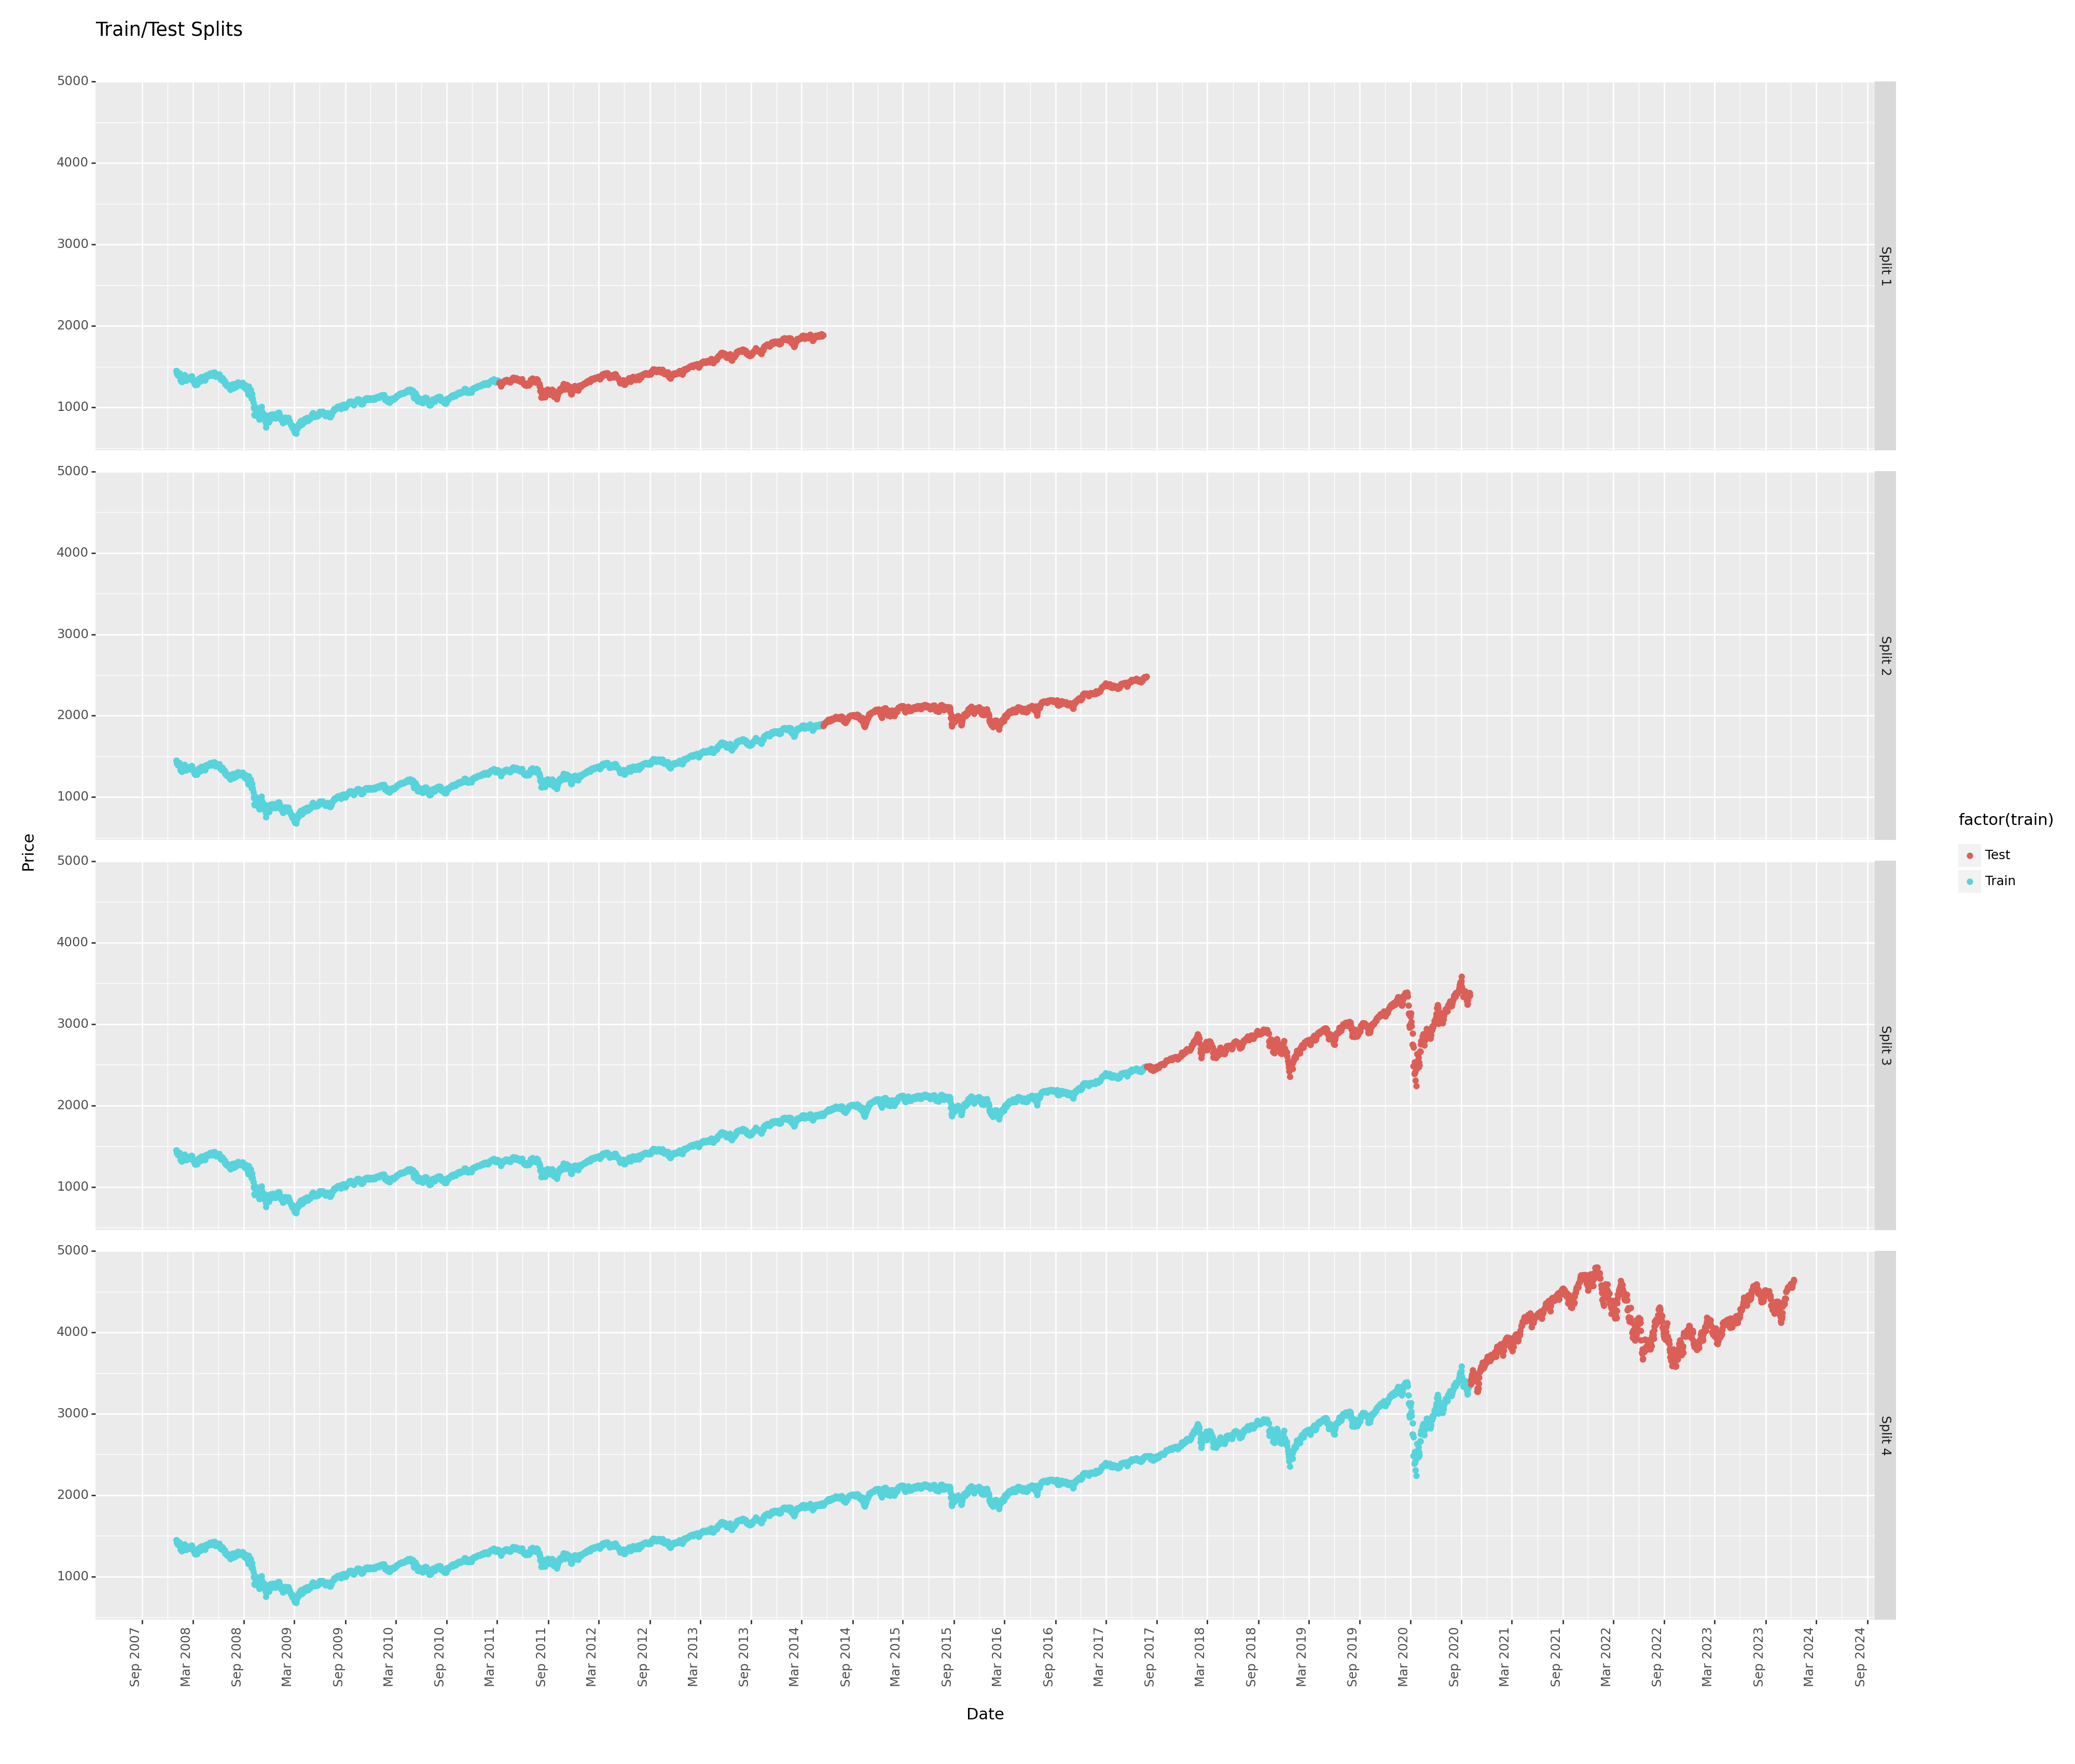

<Figure Size: (2000 x 1700)>

In [ ]:
#plot
(ggplot(df_results_1,aes("ds","y",color="factor(train)"))+
 geom_point()+
 facet_grid('split~.'))+\
 labs(title="Train/Test Splits",x="Date",y="Price")+\
 scale_x_date(date_breaks="6 months",date_labels =  "%b %Y")+\
 theme(figure_size=(20, 17), axis_text_x  = element_text(angle = 90, hjust = 1))

In [ ]:
model_cv_metrics_1

horizon           mse        rmse        mae      mape     mdape  \
0    3 days   2216.186029   47.076385  38.504839  0.036662  0.030549   
1    4 days   2335.176812   48.323667  38.389928  0.036301  0.030493   
2    5 days   2496.631607   49.966305  38.528286  0.036346  0.028238   
3    6 days   2625.766929   51.242238  39.137178  0.037185  0.029281   
4    7 days   2961.280619   54.417650  41.872278  0.039954  0.031563   
..      ...           ...         ...        ...       ...       ...   
105 26 days  16295.983782  127.655724  90.070179  0.047785  0.037081   
106 27 days  16854.503190  129.824894  89.484156  0.048264  0.035639   
107 28 days  17354.362415  131.735957  91.704811  0.049975  0.037099   
108 29 days  17920.508958  133.867505  93.569039  0.051475  0.037661   
109 30 days  17488.827277  132.245330  95.506113  0.052252  0.039615   

        smape  coverage Train/Test Split  
0    0.036950  0.747664          Split 0  
1    0.036698  0.737088          Split 0  
2    0.036872  0.740454          Split 0  
3    0.037695  0.724678          Split 0  
4    0.040351  0.705229          Split 0  
..        ...       ...              ...  
105  0.047674  0.554121          Split 3  
106  0.048086  0.575338          Split 3  
107  0.049798  0.551040          Split 3  
108  0.051305  0.539347          Split 3  
109  0.052236  0.512733          Split 3  

[110 rows x 9 columns]

In [ ]:
#tuning seasonality settings
df_results_1a, my_model_1a, model_cv_metrics_1a = pro_ds_data_gen(df_sub,yearly_seasonality=False)
df_results_1b, my_model_1b, model_cv_metrics_1b = pro_ds_data_gen(df_sub)
df_results_1c, my_model_1c, model_cv_metrics_1c = pro_ds_data_gen(df_sub, weekly_seasonality=True)
df_results_1d, my_model_1d, model_cv_metrics_1d = pro_ds_data_gen(df_sub,yearly_seasonality=False, weekly_seasonality=True)

df_dict={"year_week":df_results_1c,"none":df_results_1a,"year":df_results_1b,"week":df_results_1d}

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#searching for best seasonality setting for data
cv_frame=pd.DataFrame()
for name,frame in df_dict.items():
    #grab the one unique rmse for each split
    values_lol=frame.groupby("split").agg({"rmse":"mean"}).values
    values=[item for sublist in values_lol for item in sublist] #returns 2D array with sub-length 1, so we cpllapse
    sub_df=pd.DataFrame({"rmse":values})
    sub_df["model"]=name
    sub_df["split"]= [f'Split {i}' for i in range(1,5)]
    cv_frame=cv_frame.append(sub_df)

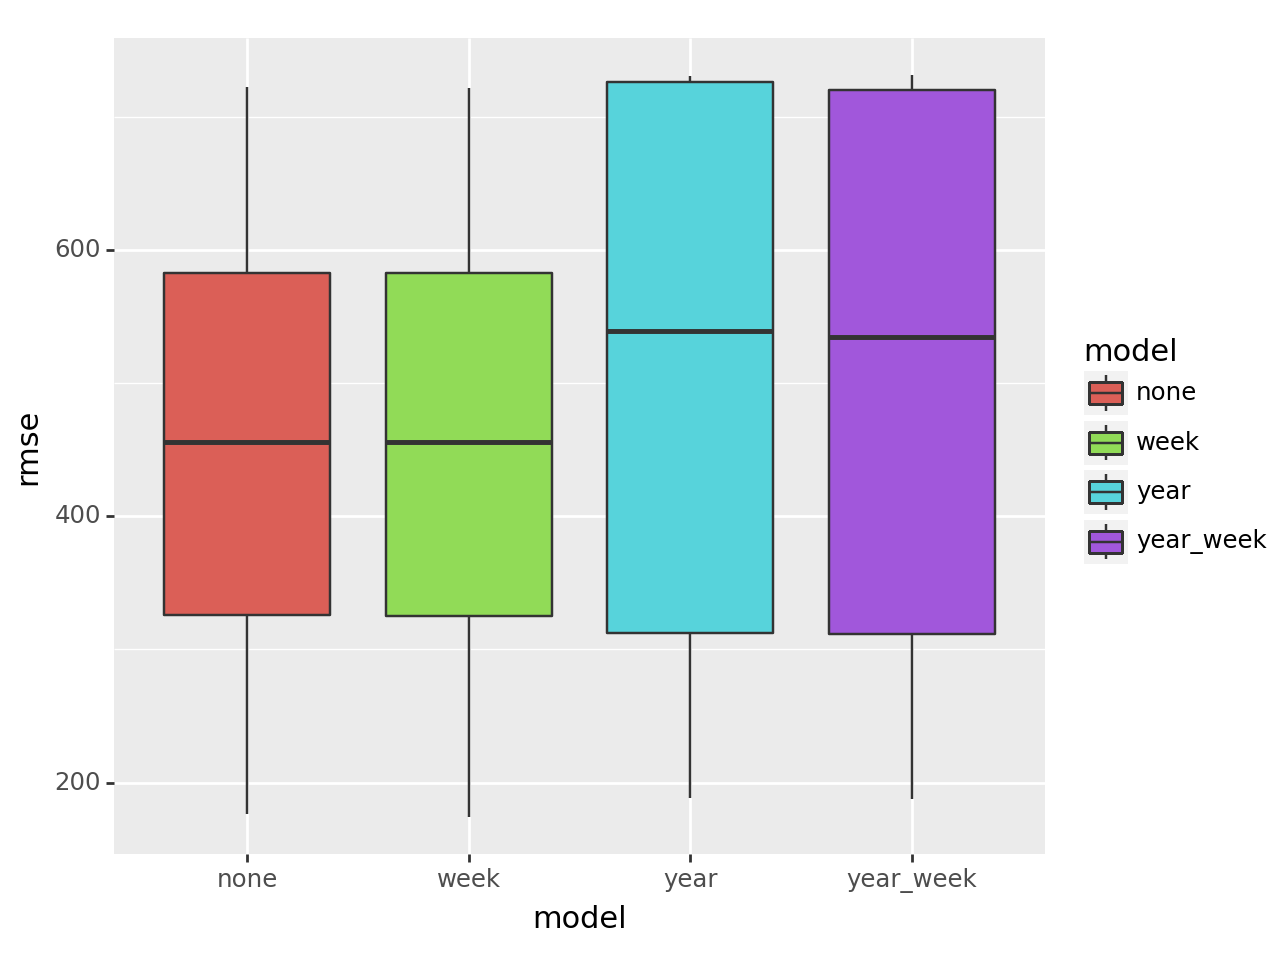

<Figure Size: (640 x 480)>

In [ ]:
(ggplot(cv_frame,aes(x="model",y="rmse",fill="model"))+geom_boxplot())

In [ ]:
#seasonality set to none or weekly works best when prophet is set to auto regression mode

##**Prophet Model 3 - Additional Stock Price Regressors with Train/Test Split and Cross Validation**

In [ ]:
# load other stock price data and use as additional regressors

#top 4 stocks in the S&P 500
df_appl = pd.read_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/StockData/All Current S&P 500 Constituents/AAPL.csv')
df_msft = pd.read_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/StockData/All Current S&P 500 Constituents/MSFT.csv')
df_amzn = pd.read_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/StockData/All Current S&P 500 Constituents/AMZN.csv')
df_nvda = pd.read_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/StockData/All Current S&P 500 Constituents/NVDA.csv')

#convert time
df_appl['Date'] = transform_to_date(df_appl['Date'])
df_msft['Date'] = transform_to_date(df_msft['Date'])
df_amzn['Date'] = transform_to_date(df_amzn['Date'])
df_nvda['Date'] = transform_to_date(df_nvda['Date'])

#copy original df for fitting
merged_df_sub = df_sub.copy()

#merge into one dataframe
merged_df_sub = pd.merge(merged_df_sub, left_on='ds',
                        right=df_appl[['Date', 'Open']], right_on='Date', how='inner')
merged_df_sub = pd.merge(merged_df_sub, left_on='ds',
                        right=df_msft[['Date', 'Open']], right_on='Date', how='inner', suffixes=('', '_msft'))
merged_df_sub = pd.merge(merged_df_sub, left_on='ds',
                        right=df_amzn[['Date', 'Open']], right_on='Date', how='inner', suffixes=('', '_amzn'))
merged_df_sub = pd.merge(merged_df_sub, left_on='ds',
                        right=df_nvda[['Date', 'Open']], right_on='Date', how='inner', suffixes=('', '_nvda'))

#rename columns - for consistency
merged_df_sub = merged_df_sub.rename(columns={'Date': 'Date_appl', 'Open': 'Open_appl'})

#show info
merged_df_sub.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4015 entries, 0 to 4014
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ds         4015 non-null   object 
 1   y          4015 non-null   float64
 2   Date_appl  4015 non-null   object 
 3   Open_appl  4015 non-null   float64
 4   Date_msft  4015 non-null   object 
 5   Open_msft  4015 non-null   float64
 6   Date_amzn  4015 non-null   object 
 7   Open_amzn  4015 non-null   float64
 8   Date_nvda  4015 non-null   object 
 9   Open_nvda  4015 non-null   float64
dtypes: float64(5), object(5)
memory usage: 345.0+ KB


In [ ]:
#add regressors to the prophet model
top4_stock_price_regressors = ['Open_appl', 'Open_msft', 'Open_amzn', 'Open_nvda']

#call main prophet function
df_results_2, my_model_2, model_cv_metrics_2 = pro_ds_data_gen(merged_df_sub, yearly_seasonality=False, add_regressors=top4_stock_price_regressors)

#get coeffs
regressor_coefficients(my_model_2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/or8ps3k2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/tyrllfeh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51781', 'data', 'file=/tmp/tmpneybixq0/or8ps3k2.json', 'init=/tmp/tmpneybixq0/tyrllfeh.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modellboul95s/prophet_model-20231213185732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  0%|          | 0/52 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/up8kt83t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/28i4r85c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8979', 'data', 'file=/tmp/tmpneybixq0/up8kt83t.json', 'init=/tmp/tmpneybixq0/28i4r85c.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modelc3kcej_3/prophet_model-20231213185732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/lz1plswz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/ajp1c4oj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/129 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/jf7e4ntn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/d1y0o2ij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13567', 'data', 'file=/tmp/tmpneybixq0/jf7e4ntn.json', 'init=/tmp/tmpneybixq0/d1y0o2ij.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modelibppaamr/prophet_model-20231213185749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/1xf579ct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/xqpywigp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/207 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/lnlb8gbl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/hw8x_h_f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37252', 'data', 'file=/tmp/tmpneybixq0/lnlb8gbl.json', 'init=/tmp/tmpneybixq0/hw8x_h_f.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modelfv7qi_b7/prophet_model-20231213185855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/4cty_g27.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/gg_3l4g4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/285 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/am8b8hrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/an3d3hg7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32241', 'data', 'file=/tmp/tmpneybixq0/am8b8hrb.json', 'init=/tmp/tmpneybixq0/an3d3hg7.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modelvmfmcno5/prophet_model-20231213190142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/k116o60b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/ejti8lbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

regressor regressor_mode     center  coef_lower       coef  coef_upper
0  Open_appl       additive  25.602159   16.439763  16.439763   16.439763
1  Open_msft       additive  53.189376   10.757909  10.757909   10.757909
2  Open_amzn       additive  34.579895   -1.226361  -1.226361   -1.226361
3  Open_nvda       additive  19.359252   -9.834548  -9.834548   -9.834548

In [ ]:
no_seasonality_regressors_rmse = df_results_2[['split', 'rmse']].drop_duplicates()
no_seasonality_regressors_rmse["model"] = 'None w. Stock Regressors'
cv_frame=cv_frame.append(no_seasonality_regressors_rmse)

In [ ]:
#update box plot
(ggplot(cv_frame,aes(x="model",y="rmse",fill="model"))+
 geom_boxplot()+
 theme(figure_size=(10, 10)))

In [ ]:
#By adding in the top 4 constituents of the S&P 500's stock price data at market open as regressors, our overall train / test split rmse is increasing

In [ ]:
#let's see which split had the highest RMSE for each model
print('Split for Highest RMSE for each Model:')
cv_frame.loc[cv_frame.groupby('model')['rmse'].idxmax()].drop_duplicates()

##**Prophet Model 4 - Additional Interest Rates and Stock Price Regressors with Train/Test Split and Cross Validation**

In [ ]:
#Adding Interest Rate Changes as additional regressors
df_interest_rates = pd.read_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/InterestRate/InterestRateSecurities.csv')

#convert date string to date
df_interest_rates['record_date'] = transform_to_date(df_interest_rates['record_date'])

#copy original df for fitting
second_merged_df_sub = merged_df_sub.copy()

#merge into one dataframe
second_merged_df_sub = pd.merge(second_merged_df_sub, left_on='ds',
                        right=df_interest_rates, right_on='record_date', how='left')

#rename columns - for consistency
second_merged_df_sub = second_merged_df_sub.rename(columns={'record_date': 'Date_interest'})

#show info
second_merged_df_sub.info()

In [ ]:
#first, impute by last value carried forward
second_merged_df_sub = second_merged_df_sub.fillna(method='ffill')

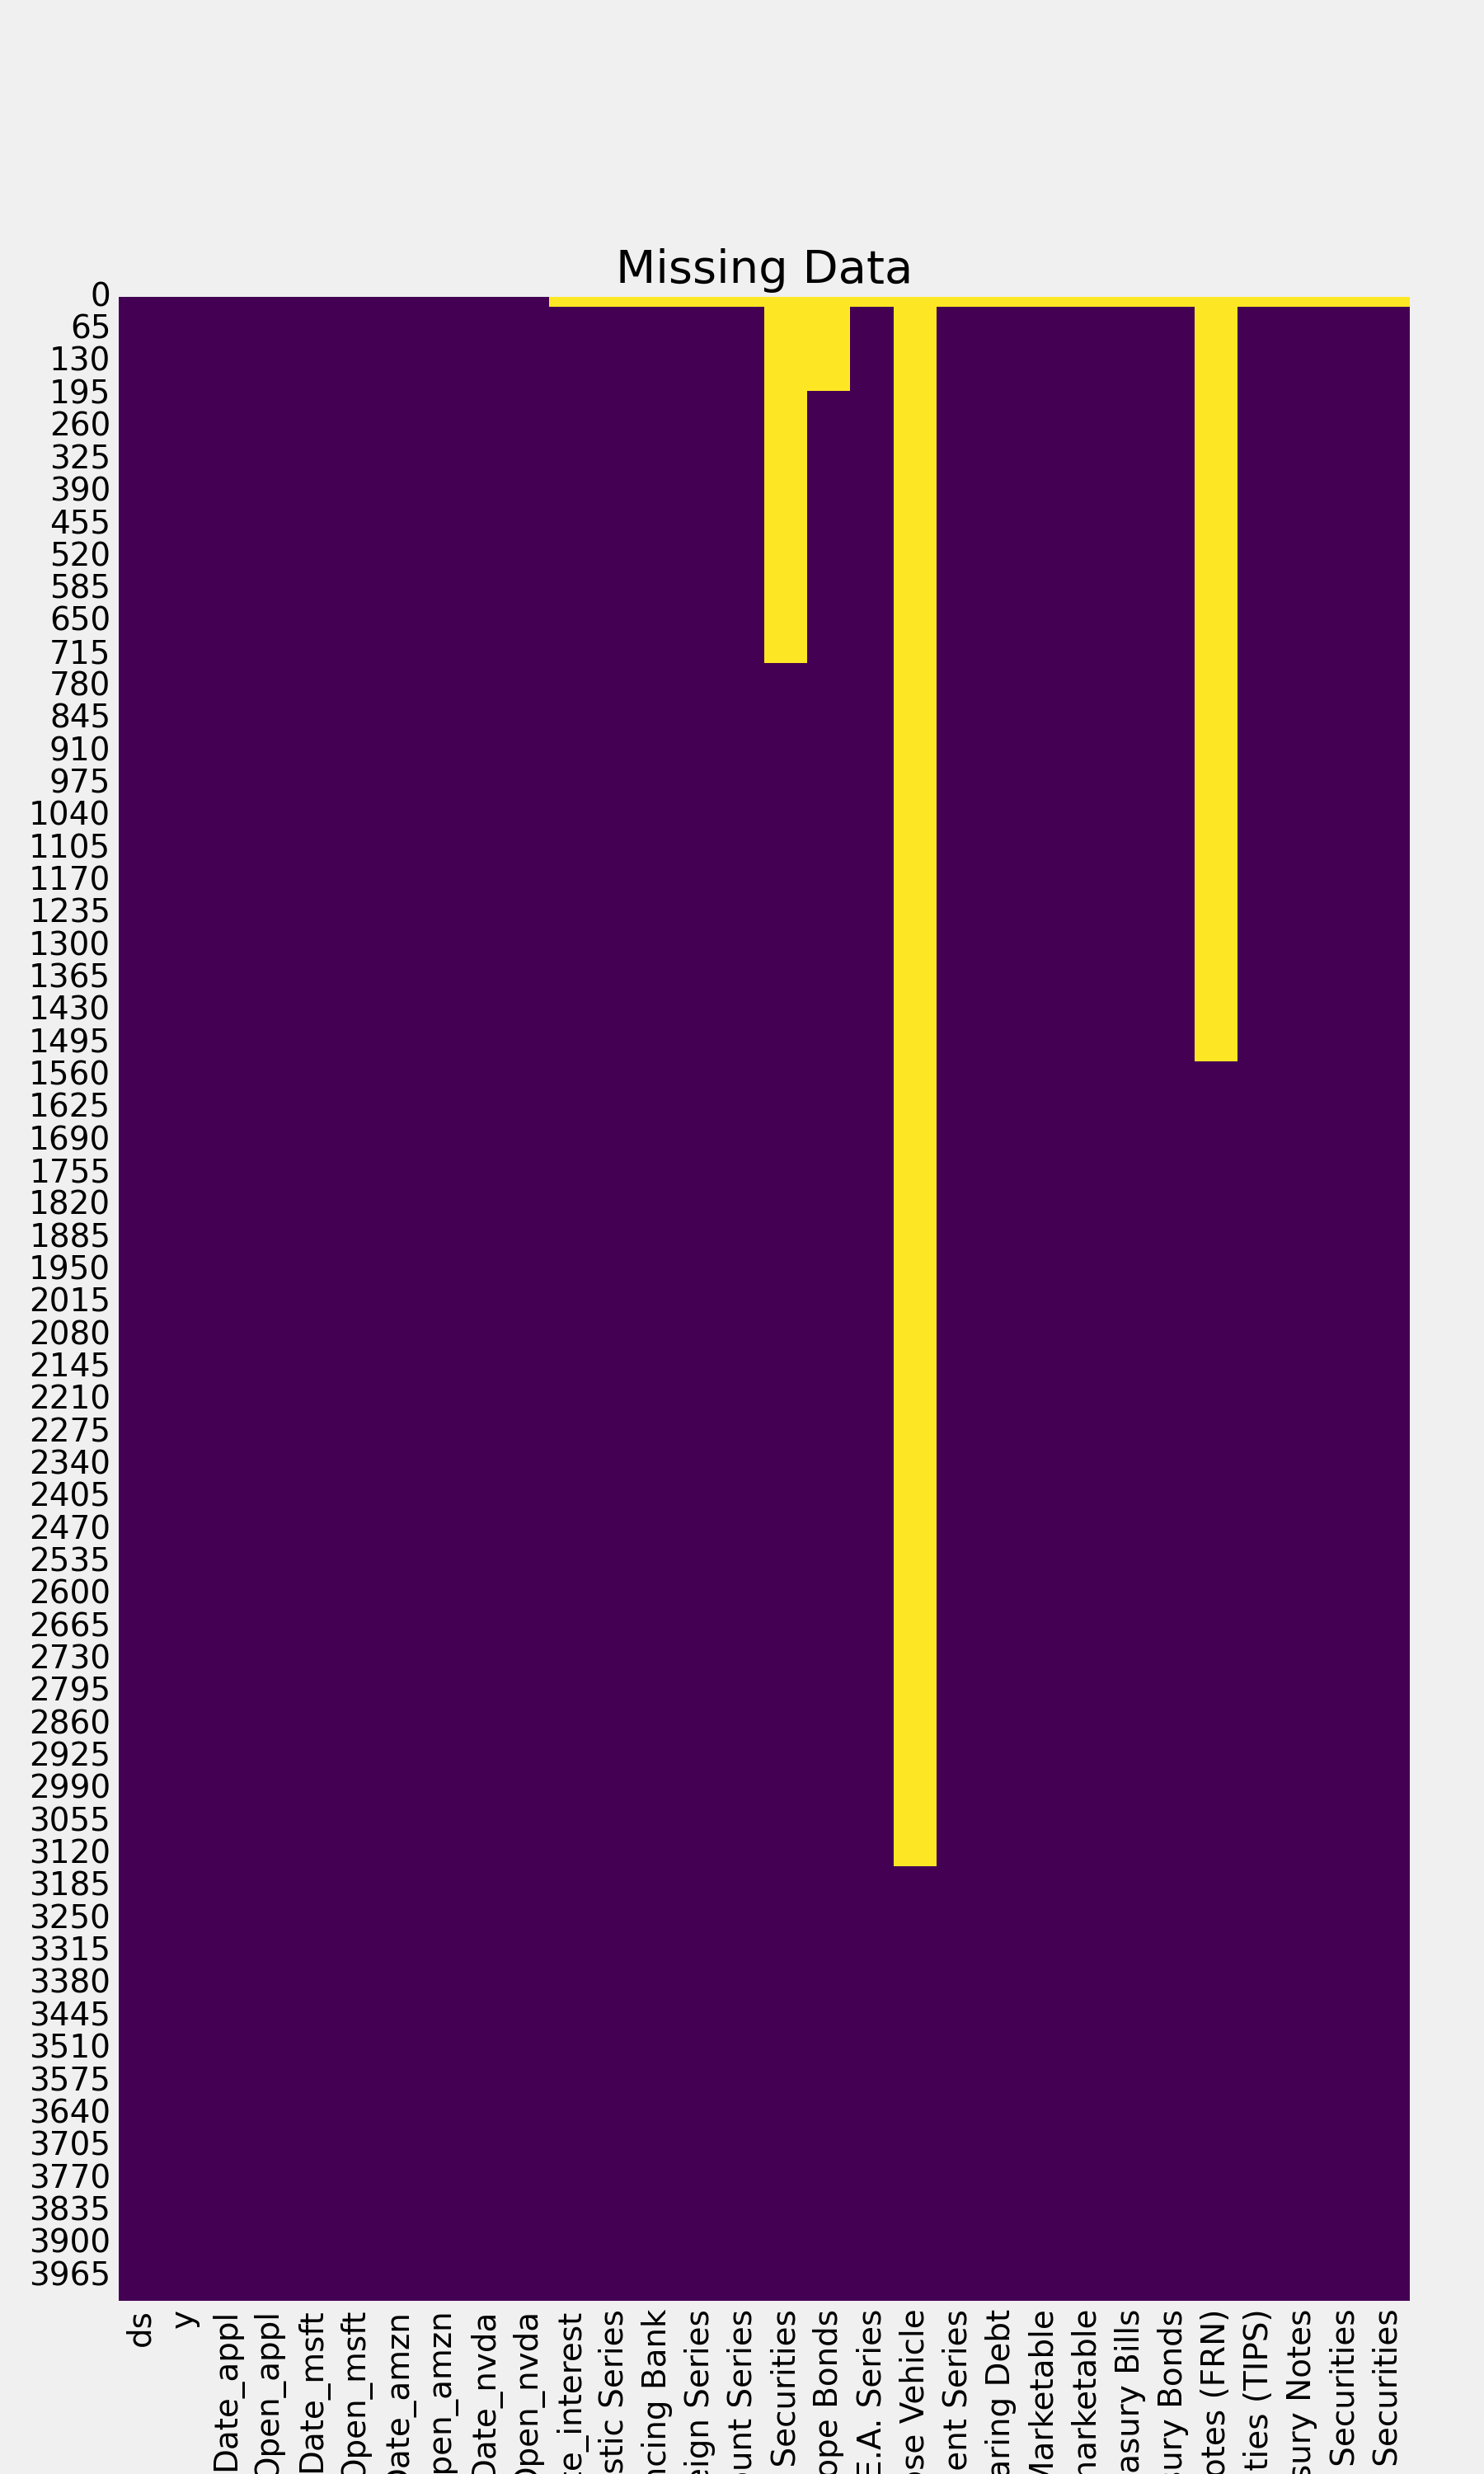

In [ ]:
import seaborn as sns

# Create a heatmap of missing data
plt.figure(figsize=(9, 15))
sns.heatmap(second_merged_df_sub.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Data')
plt.show()

In [ ]:
#prepare a list of all regressors
interest_rate_regressors = list(df_interest_rates.columns)
interest_rate_regressors.remove('record_date')
all_regressors = top4_stock_price_regressors + interest_rate_regressors
all_regressors

['Open_appl',
 'Open_msft',
 'Open_amzn',
 'Open_nvda',
 'Domestic Series',
 'Federal Financing Bank',
 'Foreign Series',
 'Government Account Series',
 'Government Account Series Inflation Securities',
 'Hope Bonds',
 'R.E.A. Series',
 'Special Purpose Vehicle',
 'State and Local Government Series',
 'Total Interest-bearing Debt',
 'Total Marketable',
 'Total Non-marketable',
 'Treasury Bills',
 'Treasury Bonds',
 'Treasury Floating Rate Notes (FRN)',
 'Treasury Inflation-Protected Securities (TIPS)',
 'Treasury Notes',
 'United States Savings Inflation Securities',
 'United States Savings Securities']

In [ ]:
#remove regressors that have more than 31 null values (more than 1 month of missing data)
for regressor in all_regressors:
  if second_merged_df_sub[regressor].isnull().sum() > 31:
    all_regressors.remove(regressor)

#make new df that drops any data points that contain nulls left over
remaining_cols = all_regressors + ['ds','y']
second_merged_df_sub_na_removed = second_merged_df_sub[remaining_cols].dropna()
second_merged_df_sub_na_removed

Open_appl   Open_msft   Open_amzn   Open_nvda  Domestic Series  \
188     3.277190   18.969603    3.292000    2.352991            7.942   
189     3.388297   19.418622    3.589000    2.419499            7.942   
190     3.269925   19.271406    3.381500    2.403445            7.942   
191     3.148525   19.411270    3.471000    2.174108            7.942   
192     2.784023   18.866546    3.203000    1.972292            7.942   
...          ...         ...         ...         ...              ...   
4010  194.449997  373.540009  147.580002  472.149994            7.577   
4011  193.630005  368.230011  146.149994  457.000000            7.577   
4012  194.199997  369.200012  145.479996  465.950012            7.577   
4013  193.110001  368.480011  145.660004  474.910004            7.577   
4014  193.080002  370.850006  145.520004  460.459991            7.577   

      Federal Financing Bank  Foreign Series  Government Account Series  \
188                    4.652           8.058                      4.835   
189                    4.652           8.058                      4.835   
190                    4.652           8.058                      4.835   
191                    4.652           8.058                      4.835   
192                    4.652           8.058                      4.835   
...                      ...             ...                        ...   
4010                   2.513           0.000                      2.876   
4011                   2.513           0.000                      2.876   
4012                   2.513           0.000                      2.876   
4013                   2.513           0.000                      2.876   
4014                   2.513           0.000                      2.876   

      Hope Bonds  R.E.A. Series  ...  Total Marketable  Total Non-marketable  \
188        1.597            5.0  ...             3.665                 4.743   
189        1.597            5.0  ...             3.665                 4.743   
190        1.597            5.0  ...             3.665                 4.743   
191        1.597            5.0  ...             3.665                 4.743   
192        1.597            5.0  ...             3.665                 4.743   
...          ...            ...  ...               ...                   ...   
4010       0.000            0.0  ...             3.155                 2.894   
4011       0.000            0.0  ...             3.155                 2.894   
4012       0.000            0.0  ...             3.155                 2.894   
4013       0.000            0.0  ...             3.155                 2.894   
4014       0.000            0.0  ...             3.155                 2.894   

      Treasury Bills  Treasury Bonds  \
188            1.607           7.095   
189            1.607           7.095   
190            1.607           7.095   
191            1.607           7.095   
192            1.607           7.095   
...              ...             ...   
4010           5.451           3.086   
4011           5.451           3.086   
4012           5.451           3.086   
4013           5.451           3.086   
4014           5.451           3.086   

      Treasury Inflation-Protected Securities (TIPS)  Treasury Notes  \
188                                            2.393           4.065   
189                                            2.393           4.065   
190                                            2.393           4.065   
191                                            2.393           4.065   
192                                            2.393           4.065   
...                                              ...             ...   
4010                                           0.624           2.244   
4011                                           0.624           2.244   
4012                                           0.624           2.244   
4013                                           0.624           2.24

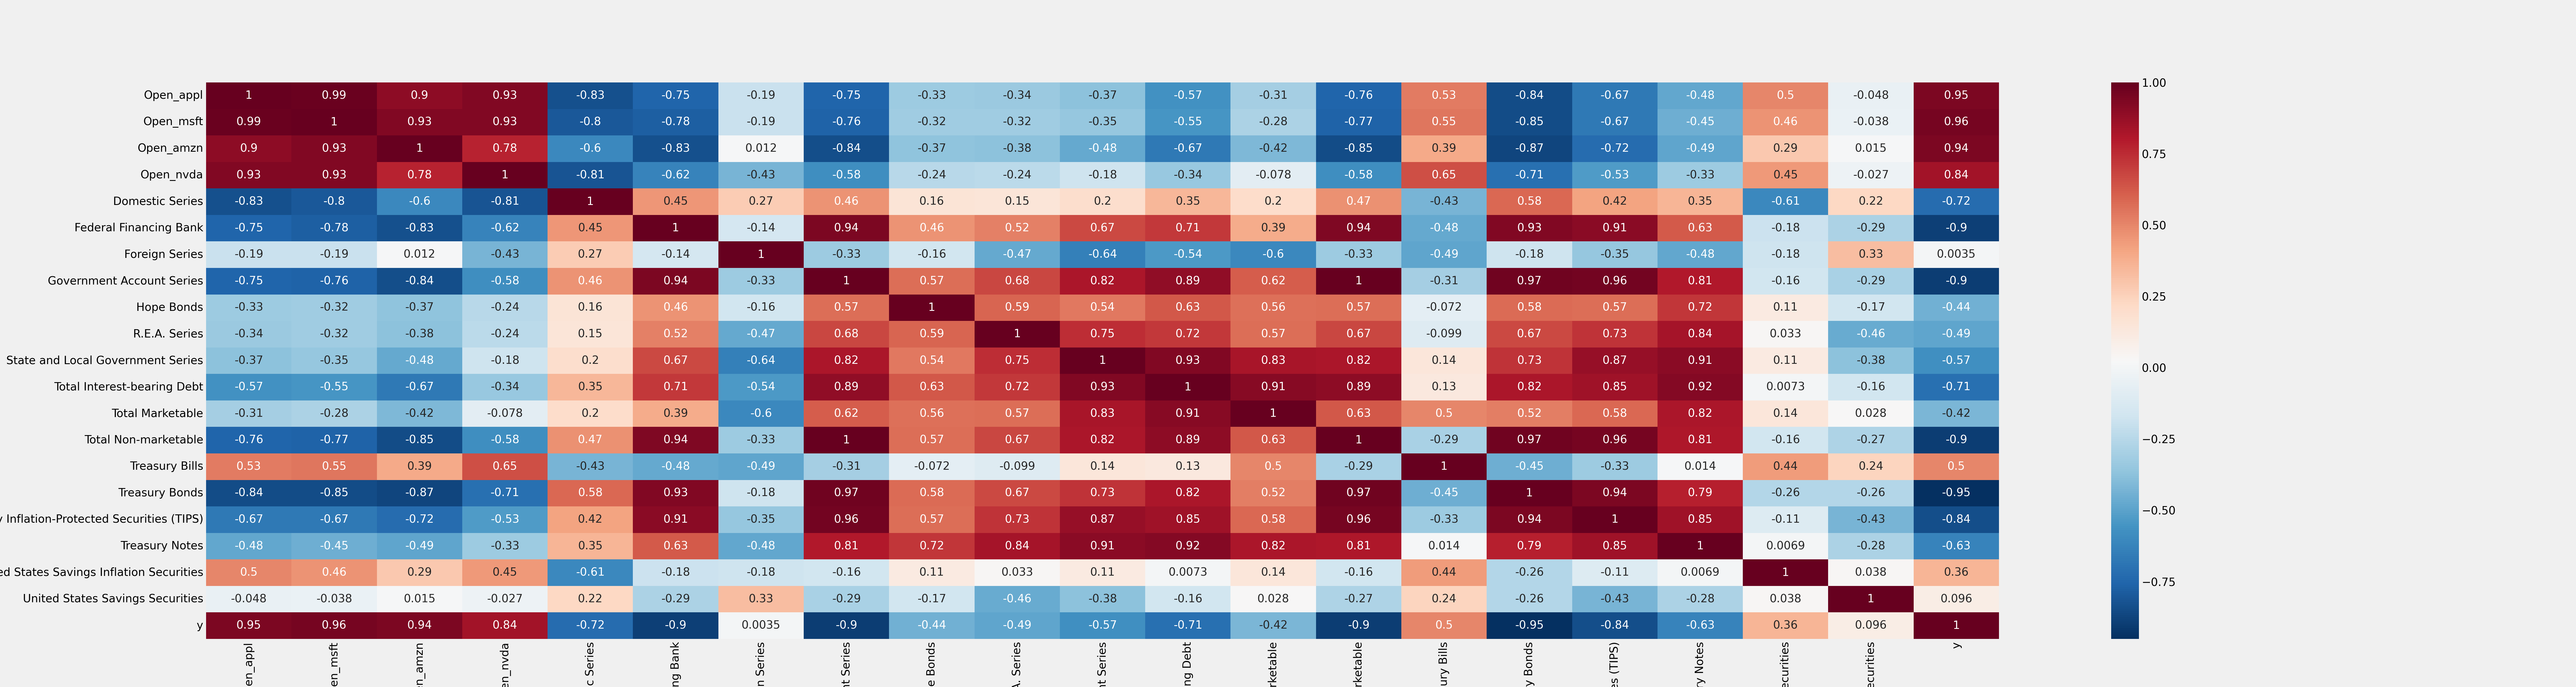

In [ ]:
#correlation analysis
plt.figure(figsize=(45,12))
sns.heatmap(second_merged_df_sub_na_removed.corr(), cmap='RdBu_r', annot=True)
plt.show()

In [ ]:
second_merged_df_sub_na_removed.corr()['y'].sort_values()

Treasury Bonds                                   -0.950641
Total Non-marketable                             -0.903657
Government Account Series                        -0.901297
Federal Financing Bank                           -0.896256
Treasury Inflation-Protected Securities (TIPS)   -0.837755
Domestic Series                                  -0.724309
Total Interest-bearing Debt                      -0.713834
Treasury Notes                                   -0.628880
State and Local Government Series                -0.571958
R.E.A. Series                                    -0.487626
Hope Bonds                                       -0.443900
Total Marketable                                 -0.421490
Foreign Series                                    0.003522
United States Savings Securities                  0.096184
United States Savings Inflation Securities        0.358320
Treasury Bills                                    0.499801
Open_nvda                                         0.8419

In [ ]:
#drop interest rate regressors between -0.8 and 0.8 correlation
interest_regressors_to_drop = ['Domestic Series',
                              'Total Interest-bearing Debt',
                              'Treasury Notes',
                              'State and Local Government Series',
                              'R.E.A. Series',
                              'Hope Bonds',
                              'Total Marketable',
                              'Foreign Series',
                              'United States Savings Securities',
                              'United States Savings Inflation Securities',
                              'Treasury Bills']

for i in interest_regressors_to_drop:
  all_regressors.remove(i)

In [ ]:
#call main prophet function
df_results_3, my_model_3, model_cv_metrics_3 = pro_ds_data_gen(second_merged_df_sub_na_removed, yearly_seasonality=False, add_regressors=all_regressors)

#get coeffs
regressor_coefficients(my_model_3)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/eou0bfzx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/7fz_kf7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39329', 'data', 'file=/tmp/tmpneybixq0/eou0bfzx.json', 'init=/tmp/tmpneybixq0/7fz_kf7q.json', 'output', 'file=/tmp/tmpneybixq0/prophet_model6vu1gm_t/prophet_model-20231213190652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  0%|          | 0/48 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/7vz7i84m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/lonala3u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95106', 'data', 'file=/tmp/tmpneybixq0/7vz7i84m.json', 'init=/tmp/tmpneybixq0/lonala3u.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modelrhoeppub/prophet_model-20231213190652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/1rendkxv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/qqb7jviv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/122 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/48hp608n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/_qaxbm16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6991', 'data', 'file=/tmp/tmpneybixq0/48hp608n.json', 'init=/tmp/tmpneybixq0/_qaxbm16.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modele8bekad2/prophet_model-20231213190709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/422xk3xy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/5p24c6b0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/196 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/x_vedc7w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/hhcv_j8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91973', 'data', 'file=/tmp/tmpneybixq0/x_vedc7w.json', 'init=/tmp/tmpneybixq0/hhcv_j8r.json', 'output', 'file=/tmp/tmpneybixq0/prophet_model04ckm782/prophet_model-20231213190819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/fo1ilate.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/bi8kqc9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/270 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/wy6j6ooa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/jcdfa59t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57374', 'data', 'file=/tmp/tmpneybixq0/wy6j6ooa.json', 'init=/tmp/tmpneybixq0/jcdfa59t.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modeli1cnbmek/prophet_model-20231213191120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:11:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:11:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/0vlo_zra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/d4e43edk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

regressor regressor_mode     center  \
0                                       Open_appl       additive  27.984454   
1                                       Open_msft       additive  57.090256   
2                                       Open_amzn       additive  38.022646   
3                                       Open_nvda       additive  21.718714   
4                          Federal Financing Bank       additive   3.739315   
5                       Government Account Series       additive   3.423689   
6                            Total Non-marketable       additive   3.387645   
7                                  Treasury Bonds       additive   5.039441   
8  Treasury Inflation-Protected Securities (TIPS)       additive   1.290012   

   coef_lower        coef  coef_upper  
0   14.926784   14.926784   14.926784  
1   10.501935   10.501935   10.501935  
2   -3.493441   -3.493441   -3.493441  
3   -5.916012   -5.916012   -5.916012  
4  -65.181119  -65.181119  -65.181119  
5  689.670204  689.670204  689.670204  
6 -268.664702 -268.664702 -268.664702  
7 -666.352135 -666.352135 -666.352135  
8  207.273790  207.273790  207.273790

In [ ]:
no_seasonality_more_regressors_rmse = df_results_3[['split', 'rmse']].drop_duplicates()
no_seasonality_more_regressors_rmse["model"] = 'None w. Stock & Interest Regressors'
cv_frame=cv_frame.append(no_seasonality_more_regressors_rmse)

In [ ]:
#update box plot
(ggplot(cv_frame,aes(x="model",y="rmse",fill="model"))+
 geom_boxplot()+
 theme(figure_size=(10, 10), axis_text_x  = element_text(angle = 90, hjust = 1)))

In [ ]:
#By introducing interest rate data as additional regressors, we see that model performs worse per RMSE score. Let's look at the coefficients of the additional regressors

##**Prophet Model 5 - Additional FOMC Sentiment Score, Interest Rates and Stock Price Regressors with Train/Test Split and Cross Validation**

In [ ]:
#Adding FOMC Sentiment Analysis Data as regressor and holidays
df_fomc_sentiment = pd.read_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/FOMC_Data_Analyzed/fomc_sentiment_analysis.csv')

#convert date string to date
df_fomc_sentiment['date'] = transform_to_date(df_fomc_sentiment['date'])

#rename columns - for consistency
df_fomc_sentiment = df_fomc_sentiment.add_prefix('fomc_')

#copy original df for fitting
third_merged_df = second_merged_df_sub_na_removed.copy()

#merge into one dataframe
third_merged_df = pd.merge(third_merged_df, left_on='ds',
                        right=df_fomc_sentiment, right_on='fomc_date', how='left')

#show info
third_merged_df.info()

In [ ]:
# Create a heatmap of missing data
plt.figure(figsize=(9, 15))
sns.heatmap(third_merged_df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Data')
plt.show()

In [ ]:
#again, impute by last value carried forward, then drop na values
third_merged_df = third_merged_df.fillna(method='ffill').dropna()

#add fomc sentiment as all_regressors list
all_regressors.append('fomc_sentiment')

In [ ]:
#define holiday
fomc_meetings_as_holidays = pd.DataFrame({
                            'holiday': 'FOMC Meetings',
                            'ds': df_fomc_sentiment['fomc_date'],
                            'lower_window': 0,
                            'upper_window': 1,
                          })

#call main prophet function
df_results_3, my_model_3, model_cv_metrics_3 = pro_ds_data_gen(third_merged_df, yearly_seasonality=False, add_regressors=all_regressors, add_holidays=fomc_meetings_as_holidays)

#get coeffs
regressor_coefficients(my_model_3)

In [ ]:
no_seasonality_even_more_regressors_rmse = df_results_3[['split', 'rmse']].drop_duplicates()
no_seasonality_even_more_regressors_rmse["model"] = 'None w. Stck, Int, & FOMC Sent. Reg.'
cv_frame=cv_frame.append(no_seasonality_even_more_regressors_rmse)

In [ ]:
#update box plot
(ggplot(cv_frame,aes(x="model",y="rmse",fill="model"))+
 geom_boxplot()+
 theme(figure_size=(10, 10), axis_text_x  = element_text(angle = 90, hjust = 1)))

##**Prophet Model 6 - All Additional Regressors (BLS Data, SEC Data, FOMC Sentiment, Interest Rates, Stock Price) with Train/Test Split and Cross Validation**

In [ ]:
#load df from saved
df_all = pd.read_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/CompliedDataset_LVCF_Imputation_Prepared.csv')

In [ ]:
#Subset to non-null values
df_all_sub = df_all.copy().dropna()

In [54]:
#define all regressors
all_regressors = list(df_all_sub.columns)
all_regressors.remove('ds')
all_regressors.remove('y')

#call main prophet function
df_results_all, my_model_all, model_cv_metrics_all = pro_ds_data_gen(df_all_sub, yearly_seasonality=False, add_regressors=all_regressors)

#get coeffs
regressor_coefficients(my_model_all)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/c2kp1lg7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/1_qled9z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95645', 'data', 'file=/tmp/tmpneybixq0/c2kp1lg7.json', 'init=/tmp/tmpneybixq0/1_qled9z.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modelxyg77uc_/prophet_model-20231213194554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:45:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/kh34auaf.json
DE

  0%|          | 0/37 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/73409ste.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/d8th0amm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87880', 'data', 'file=/tmp/tmpneybixq0/73409ste.json', 'init=/tmp/tmpneybixq0/d8th0amm.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modelss_uf3yr/prophet_model-20231213194720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:47:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/bk5_vg_6.json
DE

  0%|          | 0/99 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/r_fm825a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/881cq4et.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2293', 'data', 'file=/tmp/tmpneybixq0/r_fm825a.json', 'init=/tmp/tmpneybixq0/881cq4et.json', 'output', 'file=/tmp/tmpneybixq0/prophet_modele3bkvoh7/prophet_model-20231213201629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:16:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:16:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1272: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

  0%|          | 0/162 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/mezuwybu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/ox8k593u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43537', 'data', 'file=/tmp/tmpneybixq0/mezuwybu.json', 'init=/tmp/tmpneybixq0/ox8k593u.json', 'output', 'file=/tmp/tmpneybixq0/prophet_model28jb5y8v/prophet_model-20231213202057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1272: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

  0%|          | 0/225 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/ijknpjrd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpneybixq0/mcpw3wt0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40914', 'data', 'file=/tmp/tmpneybixq0/ijknpjrd.json', 'init=/tmp/tmpneybixq0/mcpw3wt0.json', 'output', 'file=/tmp/tmpneybixq0/prophet_model2ymjdj5q/prophet_model-20231213203031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:30:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:30:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1272: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

regressor regressor_mode  \
0                                        Unnamed: 0       additive   
1                                         AAPL_Open       additive   
2                                         MSFT_Open       additive   
3                                         AMZN_Open       additive   
4                                         NVDA_Open       additive   
..                                              ...            ...   
127  Treasury Inflation-Protected Securities (TIPS)       additive   
128                                  Treasury Notes       additive   
129      United States Savings Inflation Securities       additive   
130                United States Savings Securities       additive   
131                                       sentiment       additive   

          center  coef_lower        coef  coef_upper  
0    2070.500000   -0.906948   -0.906948   -0.906948  
1      37.405168    2.407887    2.407887    2.407887  
2      73.479819    0.643504    0.643504    0.643504  
3      50.933770    0.490225    0.490225    0.490225  
4      31.185635    0.732167    0.732167    0.732167  
..           ...         ...         ...         ...  
127     1.032532  -74.309501  -74.309501  -74.309501  
128     1.951063 -249.286447 -249.286447 -249.286447  
129     3.468047    2.972257    2.972257    2.972257  
130     3.072392  -30.244596  -30.244596  -30.244596  
131     0.815727    3.927071    3.927071    3.927071  

[132 rows x 6 columns]

In [55]:
all_regressors_rmse = df_results_3[['split', 'rmse']].drop_duplicates()
all_regressors_rmse["model"] = 'None w. All Regressors'
cv_frame=cv_frame.append(all_regressors_rmse)

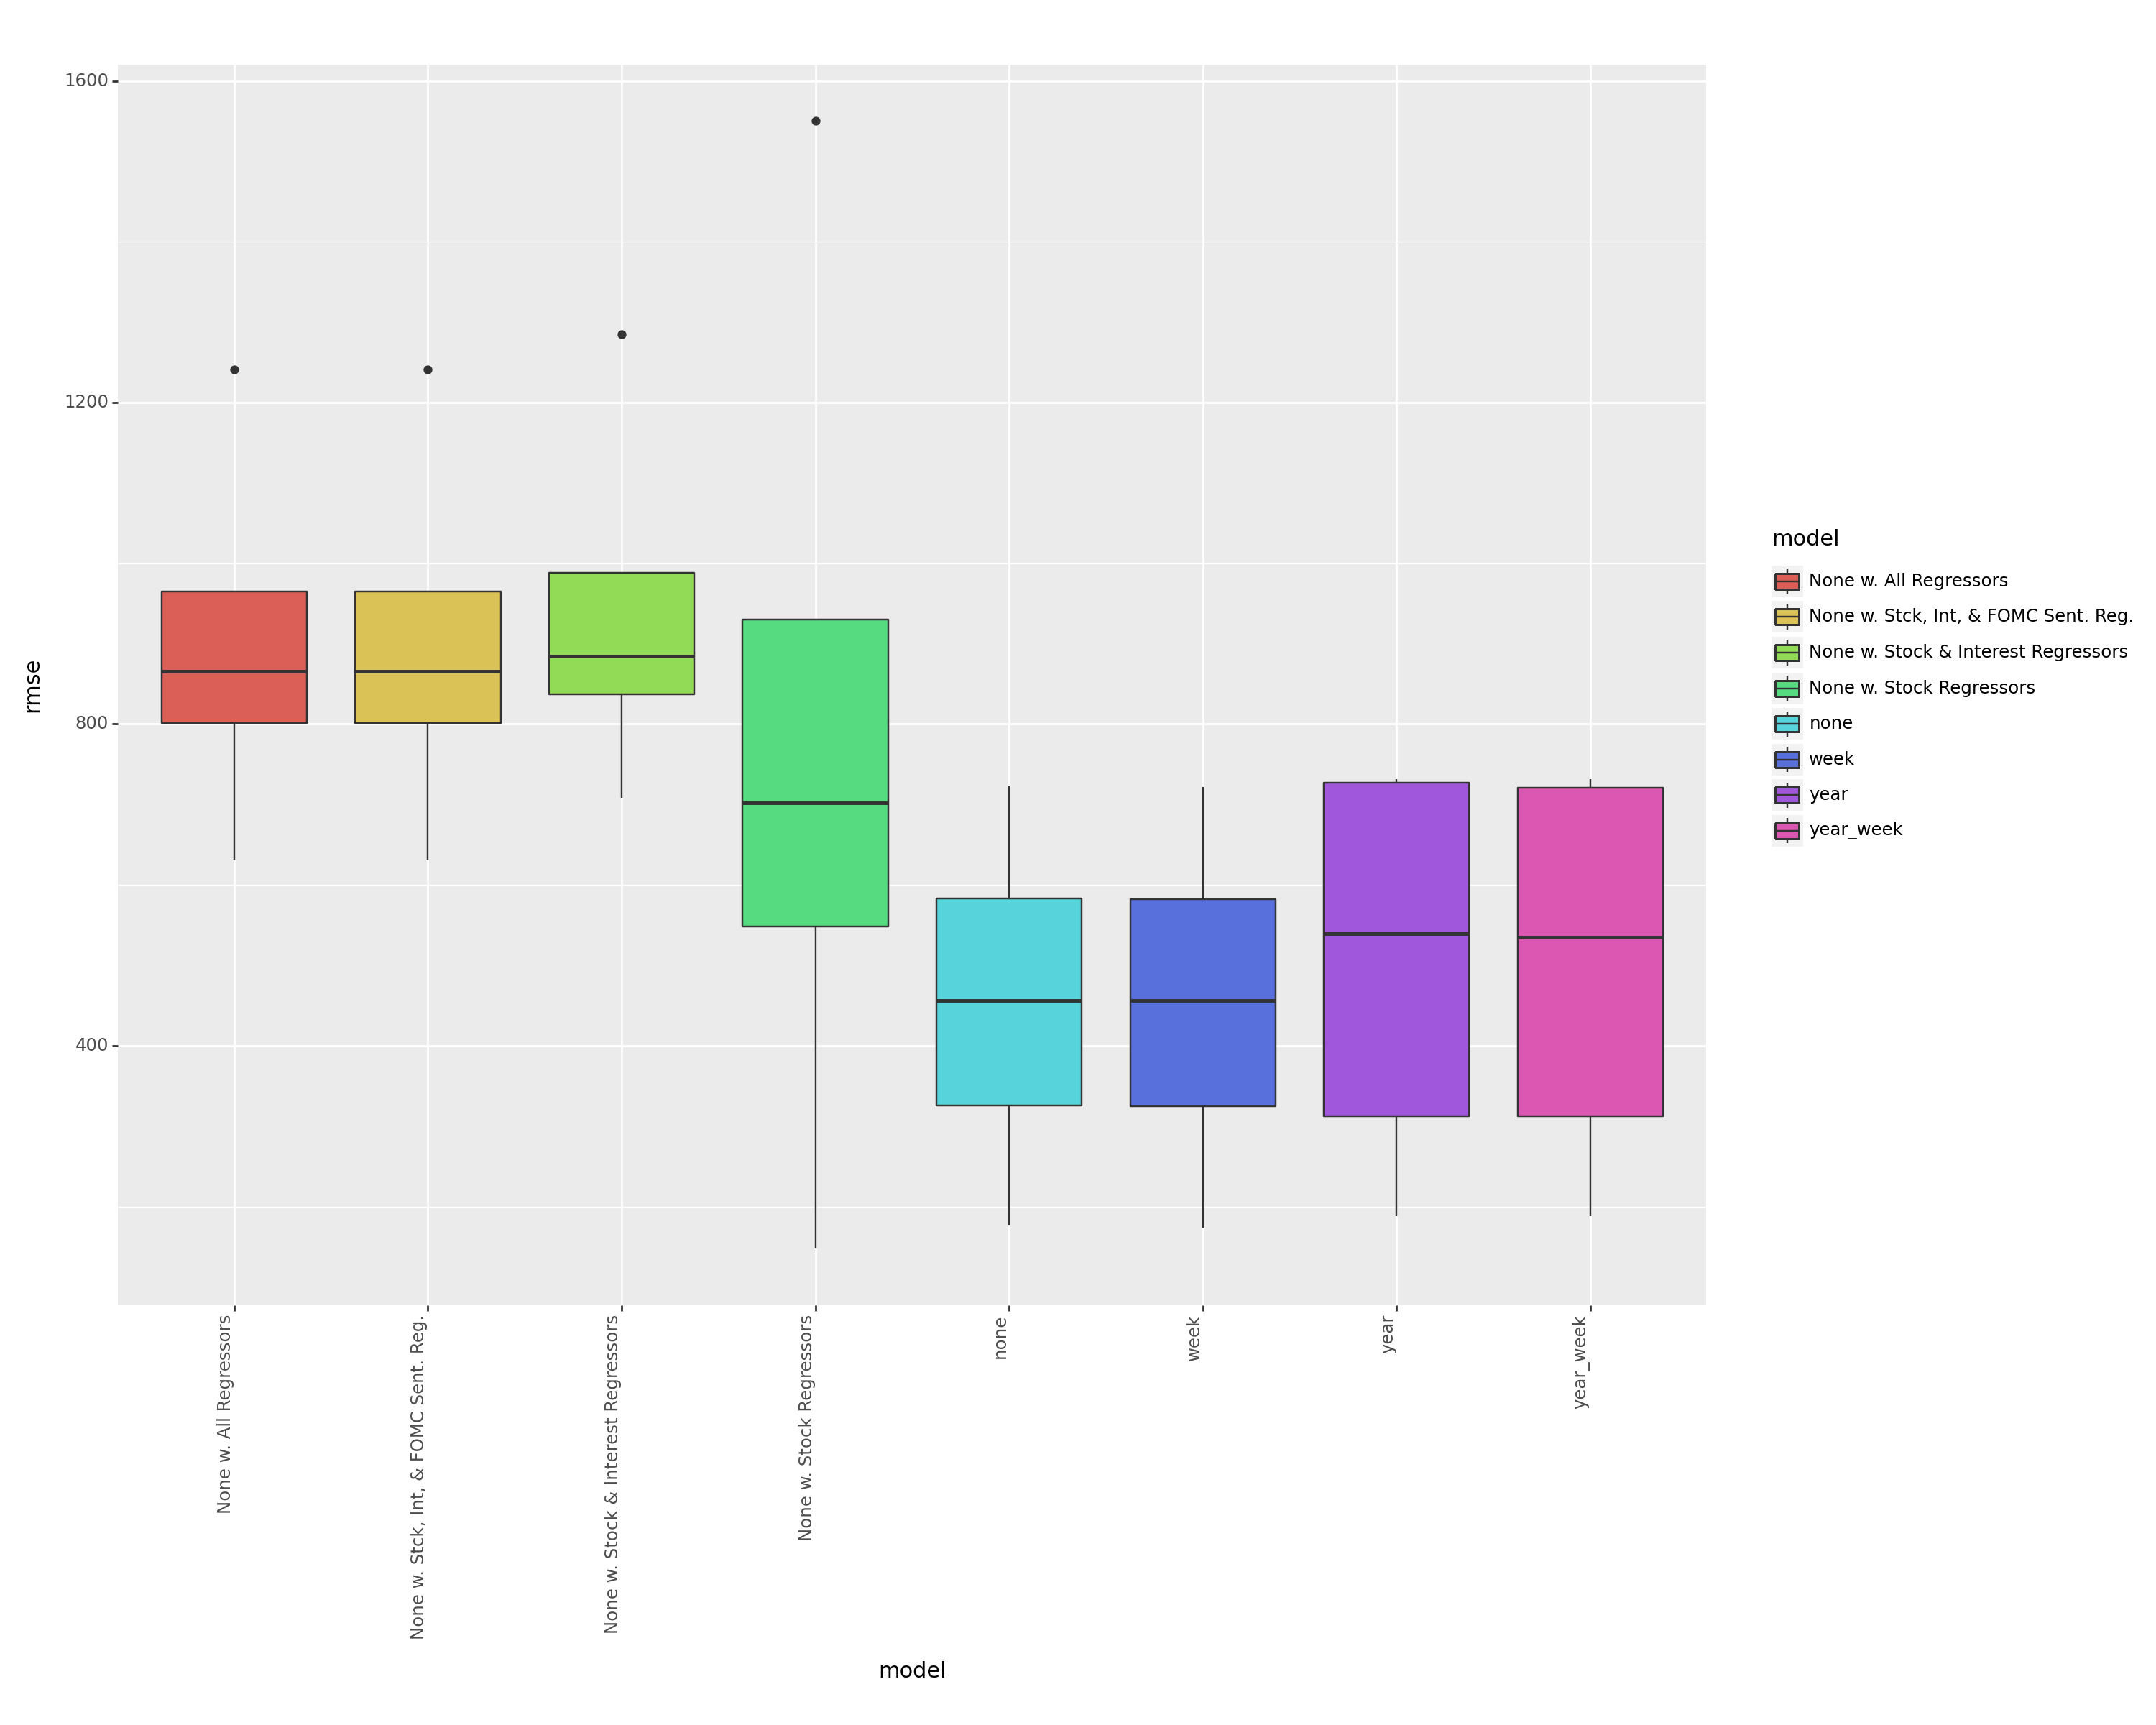

<Figure Size: (1500 x 1200)>

In [58]:
#update box plot
(ggplot(cv_frame,aes(x="model",y="rmse",fill="model"))+
 geom_boxplot()+
 theme(figure_size=(15, 12), axis_text_x  = element_text(angle = 90, hjust = 1)))